# Problem 2: Optimizing the quantity of ingredients to order

#### Summary:
As a result of our solution, we expect drastic changes to the overall demand of salad ingredients to Salad Stop. As a 
result, Salad Stop would need to be able to adjust the quantity of ingredients to be purchased based on the fluctuations in demand. As a result, we propose a long-short term memory neural network to study our time-series dataset "demand_kaggle.csv". Using this model, we predict and forecast future demand of each ingredient. We will then feed this to our stochastic model created based on historical demand and ingredient statistics (e.g. cost, price, space taken up) which will then optimize the optimal number of ingredients to order and the corresponding expected profits 

## Descriptive Analytics

In this section, we will perform data visualisations to observe the trends of different quantities of each ingredient being ordered at salad stop at a particular store in a particular day

In [1]:
"""
Import Libraries
"""

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.tseries.offsets import DateOffset

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
"""
Import dataset and formatting
"""

ingredient_demand = pd.read_csv("../data/demand_kaggle.csv", index_col=0)
ingredient_demand_transform = ingredient_demand
ingredient_demand_transform.head()

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,33,33,15,10,11,23,25,10,18,37,...,34,17,30,22,37,23,28,49,16,21
2013-01-02,37,43,30,11,6,6,23,11,23,34,...,30,25,19,22,30,6,26,48,13,28
2013-01-03,38,23,14,8,8,15,34,8,25,32,...,35,25,33,30,40,15,38,45,12,40
2013-01-04,54,18,10,19,9,13,36,19,22,45,...,46,27,24,24,48,13,38,41,23,45
2013-01-05,51,34,23,12,8,15,38,12,29,35,...,43,22,32,28,31,15,45,48,23,38


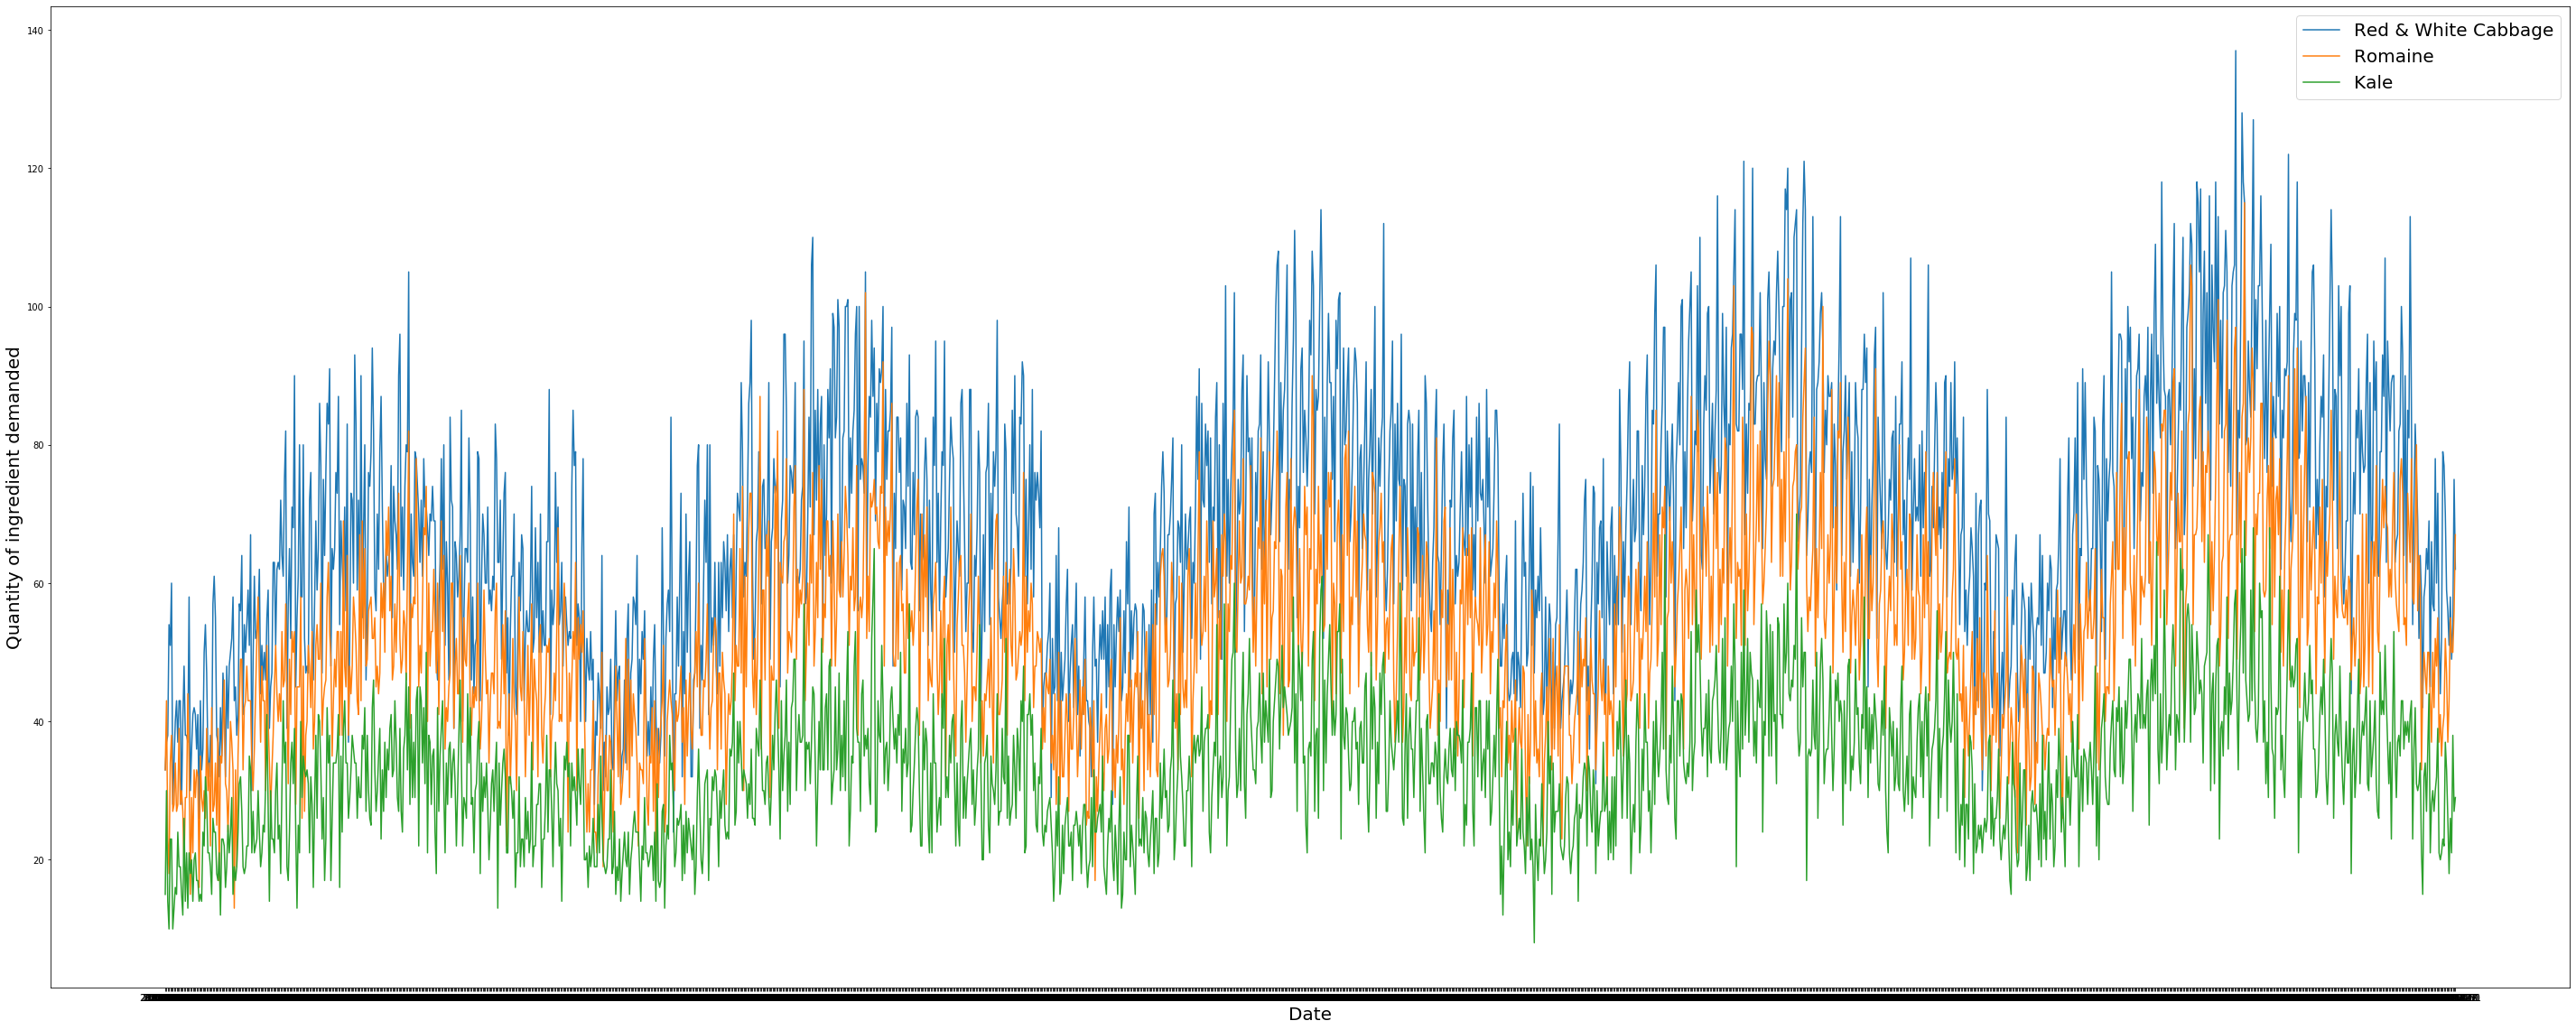

In [3]:
"""
Visualize demand for some ingredients
"""

pyplot.figure(figsize=(50,20))

for i, c in enumerate(ingredient_demand_transform.columns):
    if i == 3:
        break
    pyplot.plot(ingredient_demand_transform[c], label=c)

pyplot.ylabel('Quantity of ingredient demanded',size=20)
pyplot.xlabel('Date',size=20)
pyplot.legend(loc='upper right',fontsize=20)

pyplot.show()

## Predictive Analytics

In this section, we will perform data visualisations to observe the trends of different quantities of each ingredient being ordered at salad stop at a particular store in a particular day

In [4]:
"""
Normalize Dataset
"""

scaler = MinMaxScaler(feature_range=(0, 1))


def normalize(scaler, original, reference):
    original_inverse = scaler.fit_transform(original)
    original_inverse_df = pd.DataFrame(original_inverse)
    original_inverse_df.index = reference.index
    original_inverse_df.columns = reference.columns
    return original_inverse_df


def invert_normalize(scaler, original, reference):
    original_inverse = scaler.inverse_transform(original)
    original_inverse_df = pd.DataFrame(original_inverse)
    original_inverse_df.index = reference.index
    original_inverse_df.columns = reference.columns
    return original_inverse_df


ingredient_demand_transform_inverse = normalize(scaler, ingredient_demand_transform, ingredient_demand_transform)
ingredient_demand_transform_inverse.head()

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.079646,0.196078,0.112903,0.153846,0.235294,0.418605,0.108911,0.153846,0.0500,0.182609,...,0.142857,0.067797,0.164835,0.132353,0.14,0.418605,0.084211,0.196850,0.148148,0.015267
2013-01-02,0.115044,0.294118,0.354839,0.179487,0.088235,0.023256,0.089109,0.179487,0.1125,0.156522,...,0.104762,0.203390,0.043956,0.132353,0.07,0.023256,0.063158,0.188976,0.092593,0.068702
2013-01-03,0.123894,0.098039,0.096774,0.102564,0.147059,0.232558,0.198020,0.102564,0.1375,0.139130,...,0.152381,0.203390,0.197802,0.250000,0.17,0.232558,0.189474,0.165354,0.074074,0.160305
2013-01-04,0.265487,0.049020,0.032258,0.384615,0.176471,0.186047,0.217822,0.384615,0.1000,0.252174,...,0.257143,0.237288,0.098901,0.161765,0.25,0.186047,0.189474,0.133858,0.277778,0.198473
2013-01-05,0.238938,0.205882,0.241935,0.205128,0.147059,0.232558,0.237624,0.205128,0.1875,0.165217,...,0.228571,0.152542,0.186813,0.220588,0.08,0.232558,0.263158,0.188976,0.277778,0.145038


In [5]:
"""
Train-test split while maintaining chronology and sequence
"""

train_size = int(int(len(ingredient_demand_transform_inverse)) * 0.7)
test_size = len(ingredient_demand_transform_inverse) - train_size
v_train_size = int(train_size * 0.7)
v_validation_size = train_size - v_train_size

train = ingredient_demand_transform_inverse.iloc[0:v_train_size, :]
valid = ingredient_demand_transform_inverse.iloc[v_train_size:train_size, :]
test = ingredient_demand_transform_inverse.iloc[train_size:, :]

In [6]:
"""
Time series generators
"""

NUMBER_OF_DATA_POINTS_FROM_DATA_SET = 5
NUMBER_OF_BATCHES_OF_DATA_PER_EPOCH = 5
NUMBER_OF_FEATURES = ingredient_demand_transform_inverse.shape[1]

train_generator = TimeseriesGenerator(train.to_numpy(), train.to_numpy(), length=NUMBER_OF_DATA_POINTS_FROM_DATA_SET, batch_size=NUMBER_OF_BATCHES_OF_DATA_PER_EPOCH)
validator_generator = TimeseriesGenerator(valid.to_numpy(), valid.to_numpy(), length=NUMBER_OF_DATA_POINTS_FROM_DATA_SET, batch_size=NUMBER_OF_BATCHES_OF_DATA_PER_EPOCH)
test_generator = TimeseriesGenerator(test.to_numpy(), test.to_numpy(), length=NUMBER_OF_DATA_POINTS_FROM_DATA_SET, batch_size=NUMBER_OF_BATCHES_OF_DATA_PER_EPOCH)

In [7]:
"""
LSTM Neural Network Generation
"""

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(NUMBER_OF_DATA_POINTS_FROM_DATA_SET,NUMBER_OF_FEATURES),return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(87))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = model.fit(train_generator,epochs=100,verbose=1,validation_data=validator_generator)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
177/178 [============================>.] - ETA: 0s - loss: 0.0550WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd35ce65f80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

Epoch 63/100
178/178 [==============================] - 2s 8ms/step - loss: 0.0097 - val_loss: 0.0184
Epoch 64/100
178/178 [==============================] - 2s 10ms/step - loss: 0.0097 - val_loss: 0.0197
Epoch 65/100
178/178 [==============================] - 1s 8ms/step - loss: 0.0094 - val_loss: 0.0202
Epoch 66/100
178/178 [==============================] - 1s 6ms/step - loss: 0.0094 - val_loss: 0.0193
Epoch 67/100
178/178 [==============================] - 1s 7ms/step - loss: 0.0092 - val_loss: 0.0183
Epoch 68/100
178/178 [==============================] - 1s 6ms/step - loss: 0.0092 - val_loss: 0.0196
Epoch 69/100
178/178 [==============================] - 1s 6ms/step - loss: 0.0091 - val_loss: 0.0238
Epoch 70/100
178/178 [==============================] - 2s 9ms/step - loss: 0.0092 - val_loss: 0.0195
Epoch 71/100
178/178 [==============================] - 1s 8ms/step - loss: 0.0092 - val_loss: 0.0200
Epoch 72/100
178/178 [==============================] - 2s 9ms/step - loss: 0.008

In [8]:
"""
We will use N consecutive datapoints from the original dataset, to predict the next datapoint and store it in PREDICTION_LIST
"""

FIRST_INDEX = 0
PREDICTION_LIST = []
PREDICTION_POINTS = ingredient_demand_transform_inverse[FIRST_INDEX:FIRST_INDEX+NUMBER_OF_DATA_POINTS_FROM_DATA_SET].values.reshape((1, NUMBER_OF_DATA_POINTS_FROM_DATA_SET, NUMBER_OF_FEATURES))

for i in range(NUMBER_OF_DATA_POINTS_FROM_DATA_SET, len(ingredient_demand_transform_inverse)):   
    PREDICTION_LIST.append(model.predict(PREDICTION_POINTS)[0]) 
    FIRST_INDEX += 1
    PREDICTION_POINTS = ingredient_demand_transform_inverse[FIRST_INDEX:FIRST_INDEX+NUMBER_OF_DATA_POINTS_FROM_DATA_SET].values.reshape((1, NUMBER_OF_DATA_POINTS_FROM_DATA_SET, NUMBER_OF_FEATURES))
    
    
PREDICTION_LIST_DF = pd.DataFrame(PREDICTION_LIST)
PREDICTION_LIST_DF.columns = ingredient_demand_transform_inverse.columns

EMPTY_DF = pd.DataFrame([[np.nan] * len(ingredient_demand_transform_inverse.columns)] * NUMBER_OF_DATA_POINTS_FROM_DATA_SET, columns=ingredient_demand_transform_inverse.columns)
PREDICTION_LIST_DF = EMPTY_DF.append(PREDICTION_LIST_DF)
PREDICTION_LIST_DF.tail()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
1816,0.281811,0.297707,0.304791,0.315356,0.308468,0.318775,0.282018,0.315720,0.299035,0.326890,...,0.304786,0.273823,0.308335,0.284762,0.278073,0.318923,0.299488,0.254926,0.248229,0.308842
1817,0.299057,0.311710,0.321622,0.331264,0.321624,0.335876,0.299014,0.331527,0.315969,0.343610,...,0.320809,0.292215,0.326320,0.299734,0.297139,0.335998,0.317053,0.269833,0.260497,0.327196
1818,0.329003,0.337415,0.350727,0.360543,0.348060,0.365695,0.326847,0.360454,0.344956,0.371504,...,0.348712,0.327556,0.355165,0.331533,0.330331,0.365658,0.346946,0.297909,0.286115,0.355969
1819,0.362626,0.364212,0.378974,0.392519,0.368047,0.395942,0.355450,0.392706,0.377874,0.403062,...,0.381978,0.366304,0.388316,0.361159,0.364785,0.396028,0.383094,0.325062,0.312238,0.380522
1820,0.218784,0.243364,0.252758,0.262205,0.261943,0.263481,0.229492,0.263362,0.238200,0.270393,...,0.248438,0.222579,0.244859,0.228442,0.214985,0.264001,0.234953,0.200516,0.203172,0.249211


In [9]:
"""
Model evaluation using RMSE metric
"""

print(f"Train set RMSE for all ingredients: {np.sqrt(np.mean((np.array(PREDICTION_LIST_DF[NUMBER_OF_DATA_POINTS_FROM_DATA_SET:v_train_size])-np.array(train[NUMBER_OF_DATA_POINTS_FROM_DATA_SET:]))**2))}")
print(f"Validation set RMSE for all ingredients: {np.sqrt(np.mean((np.array(PREDICTION_LIST_DF[v_train_size:train_size])-np.array(valid))**2))}")
print(f"Test set RMSE for all ingredients: {np.sqrt(np.mean((np.array(PREDICTION_LIST_DF[train_size:])-np.array(test))**2))}")

Train set RMSE for all ingredients: 0.0860920335929946
Validation set RMSE for all ingredients: 0.13770523823597777
Test set RMSE for all ingredients: 0.1414370794263137


In [10]:
"""
Reverse min-max scaler on prediction dataframe
"""

prediction_inverse = invert_normalize(scaler, PREDICTION_LIST_DF, ingredient_demand_transform)
prediction_inverse.tail()

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,55.844640,43.366144,26.897059,16.298882,13.487910,18.707335,42.483840,16.313087,37.922770,53.592304,...,51.002517,29.155555,43.058515,32.363822,50.807292,18.713673,48.451321,56.375579,21.404369,59.458361
2017-12-28,57.793391,44.794435,27.940591,16.919280,13.935229,19.442657,44.200393,16.929540,39.277524,55.515101,...,52.684933,30.240676,44.695095,33.381918,52.713914,19.447897,50.120040,58.268787,22.066816,61.862618
2017-12-29,61.177346,47.416374,29.745046,18.061174,14.834033,20.724903,47.011549,18.057712,41.596490,58.722930,...,55.614750,32.325826,47.319980,35.544225,56.033082,20.723278,52.959859,61.834465,23.450184,65.631995
2017-12-30,64.976763,50.149652,31.496374,19.308232,15.513600,22.025518,49.900481,19.315552,44.229948,62.352115,...,59.107678,34.611959,50.336797,37.558838,59.478516,22.029217,56.393906,65.282932,24.860865,68.848337
2017-12-31,48.722606,37.823141,23.670998,14.225979,11.906063,16.329667,37.178676,14.271113,33.055965,47.095231,...,45.085971,26.132144,37.282202,28.534038,44.498549,16.352060,42.320491,49.465579,18.971291,51.646578


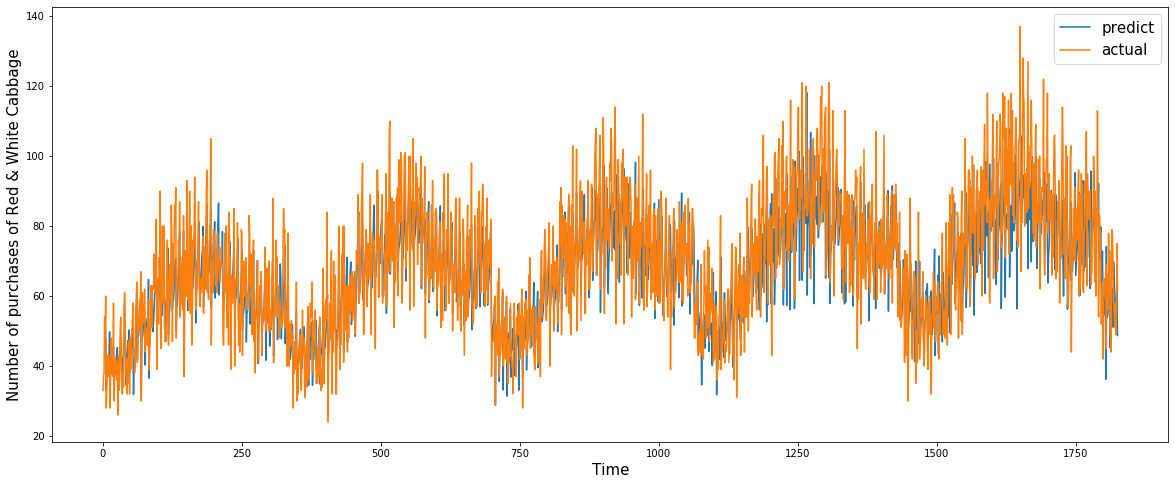

In [11]:
"""
As it is impractical to visualise all ingredients, we will pick one and observe the predicted number of ingredients 
used vs the actual number of ingredients used. Due to the fact that random number generator was used to generate the
csv files, it results in the highly skewed and inaccurate performance of the neural network.
"""

INGREDIENT_TO_EVALUATE = "Red & White Cabbage"
prediction_array = list(prediction_inverse[INGREDIENT_TO_EVALUATE])
actual_array = list(ingredient_demand_transform[INGREDIENT_TO_EVALUATE])

pyplot.figure(figsize=(20,8))
pyplot.plot(prediction_array, label='predict')
pyplot.plot(actual_array, label='actual')
pyplot.legend()

pyplot.ylabel(f'Number of purchases of {INGREDIENT_TO_EVALUATE}', size=15)
pyplot.xlabel('Time', size=15)
pyplot.legend(fontsize=15)

pyplot.show()

In [12]:
"""
We will use the last N consecutive datapoints to predict the quantity of ingredients to import outside the dataset
"""

PREDICTION_POINTS = ingredient_demand_transform_inverse[-1 * NUMBER_OF_DATA_POINTS_FROM_DATA_SET:].values.reshape((1, NUMBER_OF_DATA_POINTS_FROM_DATA_SET, NUMBER_OF_FEATURES))
NUMBER_OF_DAYS_TO_SEE_IN_THE_FUTURE = 10

ingredient_demand_transform_inverse_with_future = ingredient_demand_transform_inverse

for i in range(NUMBER_OF_DAYS_TO_SEE_IN_THE_FUTURE):   
    PREDICTION_VALUE = model.predict(PREDICTION_POINTS)[0]
    PREDICTION_VALUE_TEMP_DF = pd.DataFrame([PREDICTION_VALUE])
    PREDICTION_VALUE_TEMP_DF.columns = ingredient_demand_transform.columns
    TEMP_FRAME = [ingredient_demand_transform_inverse_with_future, PREDICTION_VALUE_TEMP_DF]
    ingredient_demand_transform_inverse_with_future = pd.concat(TEMP_FRAME)
    PREDICTION_POINTS = ingredient_demand_transform_inverse_with_future[-1 * NUMBER_OF_DATA_POINTS_FROM_DATA_SET:].values.reshape((1, NUMBER_OF_DATA_POINTS_FROM_DATA_SET, NUMBER_OF_FEATURES))


ingredient_demand_transform_inverse_with_future

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
2013-01-01,0.079646,0.196078,0.112903,0.153846,0.235294,0.418605,0.108911,0.153846,0.050000,0.182609,...,0.142857,0.067797,0.164835,0.132353,0.140000,0.418605,0.084211,0.196850,0.148148,0.015267
2013-01-02,0.115044,0.294118,0.354839,0.179487,0.088235,0.023256,0.089109,0.179487,0.112500,0.156522,...,0.104762,0.203390,0.043956,0.132353,0.070000,0.023256,0.063158,0.188976,0.092593,0.068702
2013-01-03,0.123894,0.098039,0.096774,0.102564,0.147059,0.232558,0.198020,0.102564,0.137500,0.139130,...,0.152381,0.203390,0.197802,0.250000,0.170000,0.232558,0.189474,0.165354,0.074074,0.160305
2013-01-04,0.265487,0.049020,0.032258,0.384615,0.176471,0.186047,0.217822,0.384615,0.100000,0.252174,...,0.257143,0.237288,0.098901,0.161765,0.250000,0.186047,0.189474,0.133858,0.277778,0.198473
2013-01-05,0.238938,0.205882,0.241935,0.205128,0.147059,0.232558,0.237624,0.205128,0.187500,0.165217,...,0.228571,0.152542,0.186813,0.220588,0.080000,0.232558,0.263158,0.188976,0.277778,0.145038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.386240,0.389623,0.405701,0.414044,0.399549,0.420110,0.379814,0.414120,0.402087,0.429797,...,0.408195,0.387502,0.411151,0.390227,0.390061,0.420153,0.403150,0.353198,0.335841,0.409396
0,0.435549,0.430530,0.451855,0.461749,0.438747,0.467437,0.423990,0.461743,0.450091,0.476064,...,0.454430,0.445784,0.458515,0.439924,0.443466,0.467425,0.453551,0.397601,0.376302,0.453116
0,0.472164,0.461079,0.479475,0.495455,0.456331,0.497555,0.453890,0.495413,0.486770,0.511240,...,0.493238,0.482509,0.495533,0.469843,0.478481,0.497542,0.494125,0.426141,0.404649,0.476288
0,0.380575,0.384969,0.395109,0.405112,0.387812,0.408932,0.366174,0.405202,0.395630,0.420642,...,0.400450,0.378244,0.402927,0.383600,0.379294,0.408972,0.397355,0.344197,0.329739,0.393612


In [13]:
"""
Extract forecasted demand to be used later in our stochastic model
"""

ingredient_demand_transform_with_future = invert_normalize(scaler, ingredient_demand_transform_inverse_with_future, ingredient_demand_transform_inverse_with_future)
ingredient_demand_transform_with_future = ingredient_demand_transform_with_future.astype(int)
ingredient_demand_only_future = ingredient_demand_transform_with_future[-1 * NUMBER_OF_DAYS_TO_SEE_IN_THE_FUTURE:]
ingredient_demand_transform_with_future

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
2013-01-01,33,33,15,10,11,22,25,10,18,37,...,34,17,30,22,37,22,27,49,16,21
2013-01-02,37,43,30,11,5,6,23,11,23,34,...,30,25,19,22,30,6,26,48,13,28
2013-01-03,38,23,14,8,8,15,34,8,25,32,...,35,25,33,30,40,15,38,45,12,40
2013-01-04,54,18,10,18,9,13,36,18,22,44,...,46,27,24,23,48,13,38,41,23,45
2013-01-05,51,34,23,12,8,15,38,12,29,35,...,43,22,32,28,31,15,45,48,23,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,67,52,33,20,16,23,52,20,46,65,...,61,35,52,39,62,23,58,68,26,72
0,73,56,36,22,17,25,56,22,50,70,...,66,39,56,42,67,25,63,74,28,78
0,77,60,37,23,18,26,59,23,52,74,...,70,41,60,44,70,26,66,78,29,81
0,67,52,32,19,16,22,50,19,45,64,...,61,35,51,39,60,22,57,67,25,70


## Prescriptive Analytics

Given the historical demand of each ingredient, along with the necessary information of statistics such as the pricing and costing of each ingredient, we will generate a stochastic model to optimize the quantity of ingredients to be imported and ordered by Salad Stop as well as the subsequent expected amount of profits to be earned by salad stop. We will then test our stochastic model with the forecasted demand generated by our neural network. This problem is similar to the multiple items newsvendor problem, hence our stochastic model will be greatly based on it.

#### Stochastic Model:

$$
\begin{align*}
\max \ &\sum_{i = 1}^N\left( \frac{1}{K} \sum_{k = 1}^K p_i t_{ki} - c_i x_i \right) \\
{\rm s.t.}\  & t_{ki} \leq x_i & \forall i = 1,...,N, k = 1,...,K\\
&t_{ki} \leq d_{ki} & \forall i = 1,...,N, k = i,...,K\\  
&\sum_{i = 1}^N s_i x_i \leq C\\
&x_i \geq 0 & \forall i = 1,...,N 
\end{align*}
$$

In [14]:
"""
Import Libaries
"""

from rsome import ro
from rsome import grb_solver as grb
import random

In [15]:
"""
Data preparation
"""

data1 = pd.read_csv('../data/menu.csv')
Demand_data = pd.read_csv("../data/demand_kaggle.csv")
d = Demand_data.set_index('date').tail(NUMBER_OF_DAYS_TO_SEE_IN_THE_FUTURE)
d

,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
date,,,,,,,,,,,,,,,,,,,,,
2017-12-22,77,41,22,16,6,27,39,16,39,60,...,51,29,39,36,62,27,60,70,27,59
2017-12-23,70,52,37,17,19,16,53,17,40,67,...,62,37,39,40,65,16,51,83,22,84
2017-12-24,59,47,33,11,15,25,45,11,37,88,...,55,27,65,50,70,25,53,60,35,68
2017-12-25,56,37,26,11,12,12,27,11,35,42,...,43,29,34,27,51,12,42,49,10,46
2017-12-26,51,43,18,15,10,19,51,15,30,50,...,48,27,42,33,48,19,51,38,19,49
2017-12-27,58,55,26,16,6,19,45,16,37,55,...,53,28,34,28,63,19,54,62,15,62
2017-12-28,49,50,21,20,15,20,36,20,34,63,...,61,31,46,37,36,20,50,58,18,57
2017-12-29,54,50,38,25,17,25,57,25,46,56,...,59,24,49,37,48,25,48,69,21,64
2017-12-30,75,56,27,19,22,23,60,19,37,78,...,58,33,42,25,62,23,66,68,23,66


In [16]:
"""
Assignment of pricing to our dataset

9.9: 2 Dressing + 7 Ingredient + 1 Standard Base
11.9: 2 Dressing + 7 Ingredient + 1 Premium Base

Assume that the price of each element is constant, hence:
1 Dressing: 0.99
1 Ingredient: 0.99
1 Standard Base: 0.99

Then Premium base would be the cost of standard base + the difference between premium base and standard base, hence:
1 Premium Base: 2.99
"""

Param_data = pd.DataFrame().assign(Ingredient=data1['Ingredient'], COGS=data1['COGS_per_serving'], \
                                   Ingredient_Type=data1['Ingredient_type'], Additional_Price_For_Premium_Toppings=data1['Price'], \
                                   Space = data1['Serving_size']/1000)
Param_data['Price'] = None
Param_data['Space'] = None

for i in range(Param_data.shape[0]):
    if Param_data["Ingredient_Type"][i] in ["Standard Base", "Wrap", "Grain Bowl", "Standard Topping", "Dressing (Western)", "Dressing (Asian)"]:
        Param_data["Price"][i] = 0.99
    elif Param_data["Ingredient_Type"][i] in ["Premium Base"]:
        Param_data["Price"][i] = 2.99
    elif Param_data["Ingredient_Type"][i] in ["Premium Topping"]:
        Param_data["Price"][i] = Param_data["Additional_Price_For_Premium_Toppings"][i]
    Param_data["Space"][i] = round(random.uniform(0, 1), 2)
Param_data["Min_order"] = None
Param_data["Min_order"] = pd.Series([min(Demand_data.set_index("date")[i]) for i in Demand_data.set_index("date").columns])
Param_data = Param_data.set_index('Ingredient').T
Param_data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A 

Ingredient,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce,Placeholder
COGS,0.53,1.86,3.75,0.56,0.99,1.4,0.79,0.67,1.47,1.01,...,0.83,0.75,1.19,0.75,0.34,0.29,1.07,0.85,0.25,0
Ingredient_Type,Standard Base,Standard Base,Premium Base,Premium Base,Wrap,Wrap,Wrap,Wrap,Grain Bowl,Grain Bowl,...,Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Placeholder
Additional_Price_For_Premium_Toppings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Space,0.52,0.36,0.93,0.47,0.39,1,0.48,0.98,0.82,0.06,...,0.87,0.73,0.45,0.01,0.58,0.57,0.65,0.19,0.83,0.62
Price,0.99,0.99,2.99,2.99,0.99,0.99,0.99,0.99,0.99,0.99,...,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,None
Min_order,24,13,8,4,3,5,14,4,14,16,...,13,15,13,23,5,20,24,8,19,NaN


In [17]:
"""
Extract out and format variables properly to be used later in out stochastic model
"""


def formatter_for_stochastic_optimizer(p_data, data, type_, num = 1):
    if type_ == "demand":
        return np.array(p_data.values[:,0:data.shape[1]].astype(int))
    else:
        return np.array(p_data.values[num,0:data.shape[1]].astype(np.float64))

    
demand = formatter_for_stochastic_optimizer(d, d, "demand")
price = formatter_for_stochastic_optimizer(Param_data, d, "price", 4)
cost = formatter_for_stochastic_optimizer(Param_data, d, "cost", 0)
space = formatter_for_stochastic_optimizer(Param_data, d, "space", 3)
min_order = formatter_for_stochastic_optimizer(Param_data, Demand_data.set_index("date"), "Min_order", 5)

In [18]:
"""
Generate quantities of ingredients to import by Salad Stop and the expected amount of profits:
"""

def generate_quantities_and_expected_profits(ingredient_pricing, ingredient_costing, customer_demand, ingredient_spacing, store_space, min_order=0):
    
    '''
    Construct Optimizer.
    '''
    model = ro.Model('Ingredient Order Optimizer Model')
    
    '''
    Other variables to be used later:
    '''
    number_of_days = customer_demand.shape[0]
    number_of_ingredients = customer_demand.shape[1]
    
    '''
    Initialize Decision Variables
    x is amount of ingredients to order
    t is the matrix of the amount of ingredients to order for each number of days in the dataset
    '''
    x = model.dvar(number_of_ingredients)
    t = model.dvar((number_of_days, number_of_ingredients))
    
    '''
    Objective function: Maximize the average profit to be earned by Salad Stop based on the number of ingredients to be ordered
    '''
    model.max(1/number_of_days*((t @ ingredient_pricing).sum()) - sum(x[i] * ingredient_costing[i] for i in range(number_of_ingredients)))
    
    '''
    Constraint 1: Constraint to linearize term min[px, pd] where px is the expected amount of quantity to order and pd is the expected amount of demand
    Reference: Newsvendor model formula
    '''
    model.st(t[:,i] <= x[i] for i in range(number_of_ingredients))
    
    '''
    Constraint 2: Ensure that the amount of ingredients to order for each day is less or equal to the expected demand 
    '''
    model.st(t <= customer_demand)
    
    '''
    Constraint 3: Ensure that the amount of ingredients to order for each day is less or equal than 
    '''
    model.st(ingredient_spacing @ x <= store_space)
    
    '''
    Constraint 4: Ensure that the amount of ingredients to order is at least 0 per day
    '''
    model.st(x >= min_order)
        
    '''
    Solve the model and generate results
    '''
    model.solve(grb, display = True)
    
    return x.get(), model.get()

In [19]:
"""
Test our optimizer with kaggle demand data
"""

total_space = 1000
expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, demand, space, total_space, min_order)
print('Expected profit is:', expected_amount_of_profit)
print()
expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
expected_amount_of_orders_df.set_index("Ingredient").T

Restricted license - for non-production use only - expires 2023-10-25
Being solved by Gurobi...
Solution status: 2
Running time: 0.0095s
Expected profit is: 1573.9682857142795



Ingredient,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
Quantity_to_order,24.0,13.0,8.0,17.0,3.0,5.0,14.0,4.0,14.0,16.0,...,19.0,13.0,15.0,13.0,48.0,12.0,48.0,24.0,8.0,19.0


In [20]:
"""
Testing our optimizer with forecasted data from LSTM neural network
"""
total_space = 1000
demand = formatter_for_stochastic_optimizer(ingredient_demand_only_future, ingredient_demand_only_future, "demand")
expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, demand, space, total_space, min_order)
print('Expected profit is:', expected_amount_of_profit)
print()
expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
expected_amount_of_orders_df.set_index("Ingredient").T

Being solved by Gurobi...
Solution status: 2
Running time: 0.0071s
Expected profit is: 1737.2847999999915



Ingredient,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
Quantity_to_order,24.0,13.0,8.0,22.0,3.0,5.0,14.0,4.0,14.0,16.0,...,19.0,13.0,15.0,13.0,57.0,5.0,50.0,24.0,8.0,19.0


Being solved by Gurobi...
Solution status: 2
Running time: 0.0086s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0083s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0107s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0073s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0068s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0072s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0144s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0112s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0097s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0116s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0107s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0083s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0116s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0127s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0

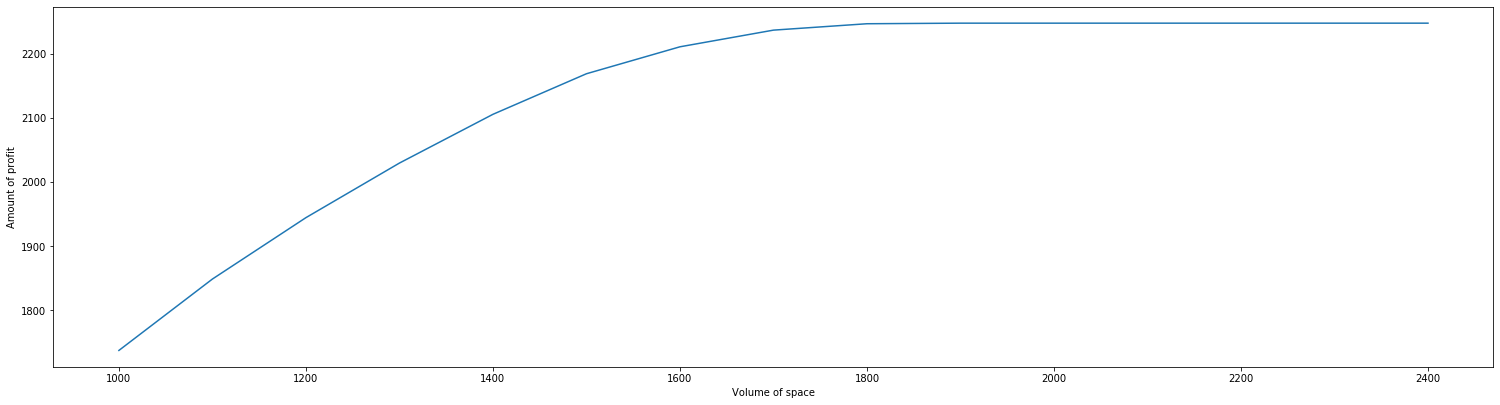

In [21]:
"""
Investigate relationship between space and profits
"""

x_volume_of_space = []
y_profit = []

for i in range(1000, 2500, 100):
    x_volume_of_space.append(i)
    expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, demand, space, i, min_order)
    y_profit.append(expected_amount_of_profit)
    
fig = plt.figure()
fig.set_size_inches(20, 5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Amount of profit')
ax.set_xlabel('Volume of space')
x = x_volume_of_space
y = y_profit
ax.plot(x,y)
plt.show()

In [22]:
"""
Optimizing order quantities in a customized basis (daily/weekly/monthly)
"""

def regular_demand_opt(basis,ingredient_pricing, ingredient_costing, customer_demand, ingredient_spacing, store_space, min_order=0):
    
    '''
    Construct Optimizer.
    '''
    model = ro.Model('Ingredient Order Optimizer Model')
    
    '''
    Other variables to be used later:
    '''
    customer_demand = Demand_data
    number_of_ingredients = customer_demand.set_index("date").shape[1]
    if basis == "D":
        cus_dem = customer_demand.set_index("date")
        number_of_periods = cus_dem.shape[0]
    elif basis == "W":
        customer_demand['date'] = pd.to_datetime(customer_demand['date'])
        cus_dem = customer_demand.groupby(pd.Grouper(freq="W",key="date")).sum()
        number_of_periods = cus_dem.shape[0]
    elif basis == "M":
        customer_demand['date'] = pd.to_datetime(customer_demand['date'])
        cus_dem = customer_demand.groupby(pd.Grouper(freq="M",key="date")).sum()
        number_of_periods = cus_dem.shape[0]

    '''
    Initialize Decision Variables
    x is amount of ingredients to order
    t is the matrix of the amount of ingredients to order for each number of periods
    '''
    x = model.dvar(number_of_ingredients)
    t = model.dvar((number_of_periods, number_of_ingredients))
    
    '''
    Objective function: Maximize the average profit to be earned by Salad Stop based on the number of ingredients to be ordered
    '''
    model.max(1/number_of_periods*((t @ ingredient_pricing).sum()) - sum(x[i] * ingredient_costing[i] for i in range(number_of_ingredients)))
    
    '''
    Constraint 1: Constraint to linearize term min[px, pd] where px is the expected amount of quantity to order and pd is the expected amount of demand
    Reference: Newsvendor model formula
    '''
    model.st(t[:,i] <= x[i] for i in range(number_of_ingredients))
    
    '''
    Constraint 2: Ensure that the amount of ingredients to order for each day is less or equal to the expected demand 
    '''
    model.st(t <= np.array(cus_dem))
    
    '''
    Constraint 3: Ensure that the amount of ingredients to order for each day is less or equal than 
    '''
    if basis == "D":
        model.st(ingredient_spacing @ x <= store_space)
    elif basis == "W":
        model.st(ingredient_spacing @ x <= store_space*7)
    elif basis == "M":
        model.st(ingredient_spacing @ x <= store_space*30)
    
    '''
    Constraint 4: Ensure that the amount of ingredients to order is at least 0 per day
    '''
    if basis == "D":
        model.st(x >= min_order)
    elif basis == "W":
        model.st(x >= min_order*7)
    elif basis == "M":
        model.st(x >= min_order*30)   
        
    '''
    Solve the model and generate results
    '''
    model.solve(grb, display = True)
    
    return x.get(), model.get()

In [23]:
# """
# Test our optimizer with kaggle demand data, generate expected quantity on a daily basis
# """

# expected_amount_of_orders, expected_amount_of_profit = regular_demand_opt("D", price, cost, demand, space, total_space, min_order)
# print('Expected profit is:', expected_amount_of_profit)
# print()
# expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
# expected_amount_of_orders_df.set_index("Ingredient").T

In [24]:
# """
# Test our optimizer with kaggle demand data, generate expected quantity on a weekly basis
# """

# expected_amount_of_orders, expected_amount_of_profit = regular_demand_opt("W", price, cost, demand, space, total_space, min_order)
# print('Expected profit is:', expected_amount_of_profit)
# print()
# expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
# expected_amount_of_orders_df.set_index("Ingredient").T

In [25]:
# """
# Test our optimizer with kaggle demand data, generate expected quantity on a monthly basis
# """

# expected_amount_of_orders, expected_amount_of_profit = regular_demand_opt("M", price, cost, demand, space, total_space, min_order)
# print('Expected profit is:', expected_amount_of_profit)
# print()
# expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
# expected_amount_of_orders_df.set_index("Ingredient").T

### Evaluate the two solutions ``order_heu`` and ``order_emp`` by using testing data

Note that the profit for any order quantity x can be obtained via:
    
``Profit = np.mean( np.minimum(x @ price, Demand_test @ price) - cost @ x )``

In [26]:
"""
Split the Demand data

Ensure that the length of the training data from the historical kaggle dataset is equal to the length of the 
data forecasted by the LSTM model.
"""

Demand_data = pd.read_csv("../data/demand_kaggle.csv")
dtr, dt = train_test_split(Demand_data.tail(NUMBER_OF_DAYS_TO_SEE_IN_THE_FUTURE+2), test_size = 1/6, shuffle = False)
dtr = dtr.set_index("date")

In [27]:
"""
Kaggle demand dataset optimisation
"""

dtr = formatter_for_stochastic_optimizer(dtr, dtr, "demand")

expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, dtr, space, total_space, min_order)
print('Expected profit is:', expected_amount_of_profit)
expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
expected_amount_of_orders_df.set_index("Ingredient").T

Being solved by Gurobi...
Solution status: 2
Running time: 0.0121s
Expected profit is: 1549.5915066666653


Ingredient,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
Quantity_to_order,24.0,13.0,8.0,17.0,3.0,5.0,14.0,4.0,14.0,16.0,...,19.0,13.0,15.0,13.0,48.0,12.0,42.0,24.0,8.0,19.0


In [28]:
"""
Kaggle demand dataset performance
"""

profit_HISTORICAL = np.mean(np.minimum(price @ expected_amount_of_orders, dt.set_index("date") @ price) - cost @ expected_amount_of_orders) 
profit_HISTORICAL

1718.2978666666672

In [29]:
"""
LSTM forecasted demand dataset optimisation
"""

total_space = 1000
demand = formatter_for_stochastic_optimizer(ingredient_demand_only_future, ingredient_demand_only_future, "demand")
expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, demand, space, total_space, min_order)
print('Expected profit is:', expected_amount_of_profit)
print()
expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
expected_amount_of_orders_df.set_index("Ingredient").T

Being solved by Gurobi...
Solution status: 2
Running time: 0.0063s
Expected profit is: 1737.2847999999915



Ingredient,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
Quantity_to_order,24.0,13.0,8.0,22.0,3.0,5.0,14.0,4.0,14.0,16.0,...,19.0,13.0,15.0,13.0,57.0,5.0,50.0,24.0,8.0,19.0


In [30]:
"""
LSTM forecasted demand dataset performance
"""

profit_LSTM = np.mean(np.minimum(price @ expected_amount_of_orders, dt.set_index("date") @ price) - cost @ expected_amount_of_orders) 
profit_LSTM

1848.9167999999997

In [51]:
"""
Evaluate performance of Stochastic Model using predicted data by LSTM vs just historical data
"""

performance_evaluation = (abs(profit_LSTM - profit_HISTORICAL)/max(profit_LSTM, profit_HISTORICAL))*100
print(f"Stochastic model optimisation based on {'LSTM forecasted demand' if profit_LSTM > profit_HISTORICAL else 'historical demand'} out performed {'historical demand' if profit_LSTM > profit_HISTORICAL else 'LSTM forecasted demand'} by {round(performance_evaluation, 3)}%")

Stochastic model optimisation based on LSTM forecasted demand out performed historical demand by 7.065%
